# Data Checks Tutorial

## Outline
1. What data do we need for demographic inference
2. Our example dataset
3. Data quality control 1: PCA
4. Data quality control 2: HWE
5. LD pruning
6. Hands on!

## 1. What data do we need for demographic inference?

- VCF with **biallelic single nucleotide variants**
- As many SNP's as possible
- As many individuals as possible (8-10 okay, 100 better)
- Remove relatives
- Use neutral sites or intergenic regions (similar evolution forces)
- Remove multiallelic, indels
- No MAF-filtering (!)
- ~~Avoid missing data~~ (`easySFS` and `ATLAS` can help with missing data)

-----
## 2.  Our example dataset

We have a dataset for clouded leopards (*Neofelis nebulosa*). It is an example data for one contig (10,000,000 bp) for 10 diploid individuals (20 haploid samples).

Let us copy data from `1_easySFS_tutorial`:

In [5]:
%%bash
cp -r ../1_easySFS_tutorial/data ./
ls data

biallelic_snps.vcf
example_data.vcf
polymorphic_snps.vcf
popmap.txt


- File `biallelic.vcf` is our VCF file with SNPs for all 10 individuals (single chromosome of 10,000,000 bp):

In [11]:
%%bash
# First five lines
head -5 data/biallelic_snps.vcf

##fileformat=VCFv4.2
##FILTER=<ID=PASS,Description="All filters passed">
##source=tskit 0.5.7
##contig=<ID=CONTIG1,length=10000000>
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">


In [10]:
%%bash
# The header line of the VCF file (we take first 9 lines of file and then show the last one)
head -9 data/biallelic_snps.vcf | tail -1

#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	Leopard01	Leopard02	Leopard03	Leopard04	Leopard05	Leopard06	Leopard07	Leopard08	Leopard09	Leopard10


- File `popmap.txt` provides population assignments per individual (all our individuals are from the same population that is marked as `NN`):

In [4]:
%%bash
cat data/popmap.txt

Leopard01 NN
Leopard02 NN
Leopard03 NN
Leopard04 NN
Leopard05 NN
Leopard06 NN
Leopard07 NN
Leopard08 NN
Leopard09 NN
Leopard10 NN


--------
## 3. Data quality control 1: PCA

Now we will check for the quality of samples. We would run principal component analysis (PCA) to check for the population structure.

**Principal Component Analysis (PCA)** helps to summarize genetic variation across individual samples into a few principal components, each representing a direction of maximum variance. By plotting these components, researchers can visually assess population structure, detect outliers, and identify subgroups or clusters within the data. This allows for quality control by highlighting samples that differ significantly from the main population, which may indicate technical artifacts, mislabeling, or underlying biological differences.

**Recommendations for Performing PCA in Genetic Data Analysis:**

* **Apply PCA to all samples across all populations:**
begin by running PCA on the entire dataset, including all samples from all populations, to assess overall population structure.

* **Check both all variants and LD-pruned variants:**
perform PCA on both the full set of variants and on independent variants (after LD pruning).

* **Repeat PCA within each population:**
analyze populations separately to detect within-population substructure and outliers.

* **Check for outliers and anomalies:**
review PCA plots to identify any outlier or mislabeled samples.

You can do PCA plot using `plink`, you can find detailed instructions [here](https://speciationgenomics.github.io/pca/). However, today we are going to use custom scripts for that.

To have a nice picture in this notebook we will use the script through python:

[INFO] Reading popmap...
[INFO] 10 samples, 1 populations detected
[INFO] Reading VCF (this might take a while)...
[INFO] Data shape after filtering: (10, 544032)
[INFO] Running PCA...
[INFO] Displaying ...


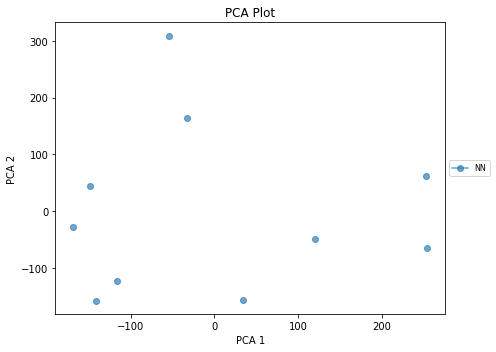

[INFO] Done.


In [7]:
from scripts.draw_PCA_plot import pca_plot

# To save to a file:
pca_plot(vcf_file="data/biallelic_snps.vcf",
         popmap_file="data/popmap.txt",
         output_file=None,  # output here
         only_full_data=False,  # missing data will be filled with mean values
         double_ids=True,
         show_sample_names=False,  # If True sample names will be pictured on the plot
)

However, you can run script from command line the following way (the same picture will appear if you use it from the command line interface):

In [8]:
%%bash
python scripts/draw_PCA_plot.py --help

usage: draw_PCA_plot.py [-h] [--full] [--show-sample-names] [--double-ids]
                        vcf popmap [output]

Draw PCA plot from VCF and popmap files.

positional arguments:
  vcf                  VCF filename
  popmap               Popmap filename (tab-separated: sample pop)
  output               Output file for the plot (e.g., pca.png); if omitted,
                       plot will be shown interactively

options:
  -h, --help           show this help message and exit
  --full               Use only full data rows (exclude missing genotypes)
  --show-sample-names  Display sample names on the plot at each point
  --double-ids         VCF contains doubled ids for samples (result of LD
                       pruning using plink)


In [9]:
%%bash
python scripts/draw_PCA_plot.py --show-sample-names data/biallelic_snps.vcf data/popmap.txt my_pca.pdf

[INFO] Reading popmap...
[INFO] 10 samples, 1 populations detected
[INFO] Reading VCF (this might take a while)...
[INFO] Data shape after filtering: (10, 544032)
[INFO] Running PCA...
[INFO] Saving to my_pca.pdf ...
[INFO] Done.


## 4. Data quality control 2: HWE

An additional sanity check is the test for Hardy-Weinberg Equilibrium (HWE). Deviations from HWE (such as a significant excess or deficit of heterozygotes or homozygotes) can indicate genotyping problems or high inbreeding coefficient (e.g. in selfing species).

The HWE principle describes the expected distribution of genotype frequencies (homozygotes and heterozygotes) under conditions of random mating, no selection, and no population structure. In well-behaved, high-quality genetic datasets, most loci are expected to approximately follow these theoretical proportions.

By drawing an HWE ternary plot, we can visually assess whether our data conform to these expectations or if systematic deviations exist. Such deviations may be early warning signs of technical issues in the dataset (for example, genotyping errors, sample contamination, or problematic variants), or reflect biological factors such as inbreeding or population substructure.

<div>
<img src="pictures/HWE_ternary_plot_example.png" width="300" align="left" />
</div>
Source: Graffelman & Camarena (2008)

**What are ternary coordinates?**
<div>
<img src="pictures/ternary_coordinates.png" width="300" align="left" />
</div>

[Source](https://demonstrations.wolfram.com/BasicTernaryPhaseDiagram/)


The paper by [Graffelman & Camarena (2008)](https://doi.org/10.1159/000108939)  describe both statistical tests and graphical tools for assessing Hardy-Weinberg equilibrium. Their paper introduces the use of chi-squared and continuity-corrected chi-squared tests to identify deviations from HWE, and shows how to visualize the **acceptance region**—where genotype frequencies are consistent with HWE at a chosen significance level (e.g., α = 0.05)—on the ternary plot.

Methods from the paper are implemented in [R library `HardyWeinberg`](https://doi.org/10.32614/CRAN.package.HardyWeinberg). The ternary plot is available via the HWTernaryPlot function. For users working with VCF data, files can be loaded into R using the [`vcfR` package](https://doi.org/10.32614/CRAN.package.vcfR). Example result:
<div>
<img src="pictures/Rplot_HWE.png" width="500" align="left" />
</div>

**Recommendations for Testing Hardy-Weinberg Equilibrium (HWE):**

* **Test HWE for each population separately:**
build HWE ternary plots within each population.

* **Check both all variants and LD-pruned variants:**
perform HWE check on both the full set of variants and on independent variants (after LD pruning).

* **Investigate Excess Heterozygosity:**
Check for variants with excess heterozygotes, as this may indicate genotyping errors or technical artifacts.

* **Monitor for Excess Homozygosity:**
Observe variants with unusually high levels of homozygosity, which could reflect inbreeding.

In this tutorial, we will use a modified python version of the approach from [Graffelman & Camarena (2008)](https://doi.org/10.1159/000108939). The solid lines present the acceptance region ($\alpha=0.05$) for HWE based on $\chi^2$ test and dashed lines refer to acceptance region ($\alpha=0.05$) for a $\chi^2$ test with continuity correction.

/home/enoskova/Workspace/GADMA_workshops/2025-12-Demographic_Inference_Worshop/tutorials/1_data_checks_tutorial/scripts/draw_HWE_ternary_plot.py:143: RuntimeWarning: invalid value encountered in sqrt
  delta = np.sqrt(


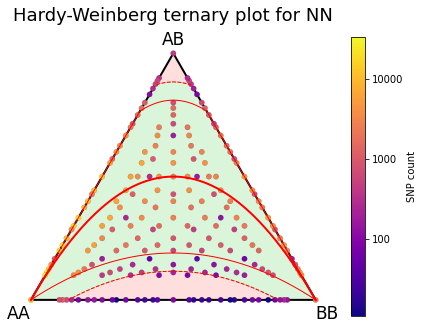

In [10]:
from scripts.draw_HWE_ternary_plot import hwe_ternary_plot

# To save to a file:
hwe_ternary_plot(vcf_file="data/biallelic_snps.vcf",
                 popmap_file="data/popmap.txt",
                 population_name="NN"
)

In order to run script from command line:

In [11]:
%%bash
python scripts/draw_HWE_ternary_plot.py --help

usage: draw_HWE_ternary_plot.py [-h] [-o OUTPUT] [--double-ids]
                                vcf popmap population

Draw a Hardy-Weinberg ternary plot for one population using a VCF and popmap.
Green background shows 'inside bounds', red otherwise.

positional arguments:
  vcf                   Input VCF file
  popmap                Popmap file
  population            Population name (as in popmap)

options:
  -h, --help            show this help message and exit
  -o OUTPUT, --output OUTPUT
                        Output file (default: interactive)
  --double-ids          VCF contains doubled ids for samples (result of LD
                        pruning using plink)


In [12]:
%%bash
python scripts/draw_HWE_ternary_plot.py --output HWE_ternary_plot.pdf data/biallelic_snps.vcf data/popmap.txt NN

/home/enoskova/Workspace/GADMA_workshops/2025-12-Demographic_Inference_Worshop/tutorials/1_data_checks_tutorial/scripts/draw_HWE_ternary_plot.py:143: RuntimeWarning: invalid value encountered in sqrt
  delta = np.sqrt(


[INFO] Saved plot to HWE_ternary_plot.pdf


-----
## 5. LD pruning
Linked sites can influence PCA and HWE plots. **It is worth checking if the plots are similar for LD pruned data.**

In order to do LD pruning, we will use `plink` (the download is available [here](https://www.cog-genomics.org/plink/)).

#### Install `plink`
We are installing plink for Linux system, you can use the following link for MacOS: `https://s3.amazonaws.com/plink1-assets/plink_mac_20250819.zip`.

In [ ]:
%%bash
mkdir plink
cd plink
wget https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20250819.zip
unzip plink_linux_x86_64_20250819.zip

check that `plink` is working:

In [ ]:
%%bash
./plink/plink --help

#### Run LD pruning using `plink`

We are using the following arguments:
- `--vcf` — specifies the location of your VCF file.
- `--double-id`  — sets both family and individual IDs in the PLINK files to your sample ID. This is necessary because PLINK expects separate family and individual IDs (for pedigree analysis), but for most population genetic analyses, duplicating the sample ID is sufficient.
- `--allow-extra-chr` — allows chromosomes beyond the standard human set (1-22, X, Y, MT). This is required if your VCF uses non-human or custom chromosome names.
- `--set-missing-var-ids @:#` — assigns variant IDs in the format chromosome:position when IDs are missing. Many non-human VCFs don't have SNP names, so this ensures PLINK can uniquely identify each variant.
- `--indep-pairwise 50 5 0.1` — performs LD pruning. Here, 50 is the window size in SNPs, 10 is the step size (how far the window advances), and 0.1 is the r² threshold; SNPs with stronger LD than this threshold are pruned out.
- `--out` — sets the prefix for all output files.

In [ ]:
%%bash
./plink/plink --vcf data/biallelic_snps.vcf --double-id --allow-extra-chr --set-missing-var-ids @:# --indep-pairwise 50 5 0.1 --out data/pruned_variants

Now we will convert our pruned variants back to VCF format. Our final file is `data/pruned_variants.vcf`.

In [ ]:
%%bash
./plink/plink --vcf data/biallelic_snps.vcf --double-id --allow-extra-chr --set-missing-var-ids @:# --extract data/pruned_variants.prune.in --recode vcf --out data/pruned_variants

## 6. Hands on!

Now it’s your turn to practice data checking!

After completing your analyses and looking at the resulting plots, can you already say something about the demographic history of these two populations? What patterns or signals do you see in your results?